In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HandyFunctions import calc_scale_height, convert_rprs_to_rpJ, calc_scale_height_error

Velocity Profile During Transit

In [2]:
tc = 0.
P = 1.0
r = 5.0
times = np.linspace(-0.25, 0.05, 100)

phases = 2.*np.pi*(times - tc) / P
xs = r*np.cos(phases)
ys = r*np.sin(phases)

vorb = 100.
vx = vorb*np.cos(phases)
vy = vorb*np.sin(phases)

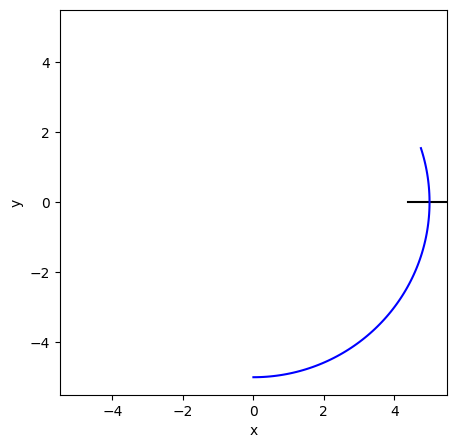

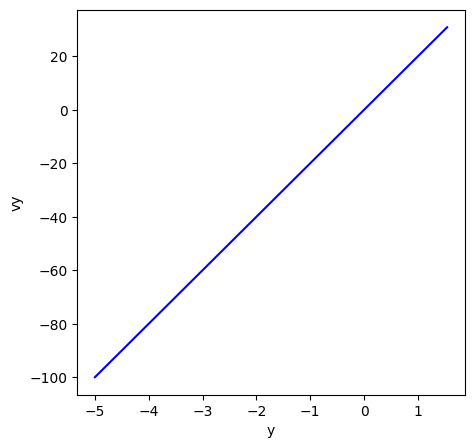

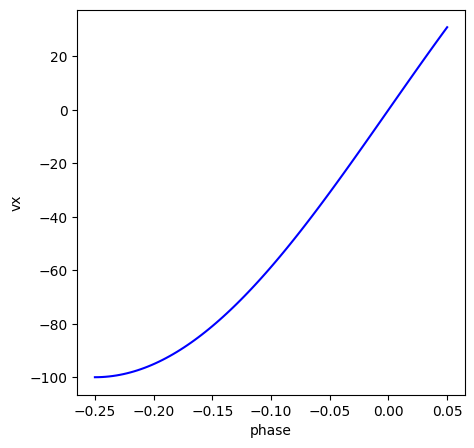

In [3]:
fig, ax = plt.subplots(figsize=(5,5))
ax.axhline(0., xmin=0.9, xmax=1.0, c='black')
ax.plot(xs, ys, c='blue')
ax.set(xlim=(-5.5,5.5), ylim=(-5.5,5.5))
ax.set(xlabel='x', ylabel='y')
plt.show()

# fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(times, phases/(2.*np.pi), c='blue')
# ax.set(xlabel='time', ylabel='phase')
# plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(ys, vy, c='blue')
ax.set(xlabel='y', ylabel='vy')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(phases/(2.*np.pi), vy, c='blue')
ax.set(xlabel='phase', ylabel='vx')
plt.show()

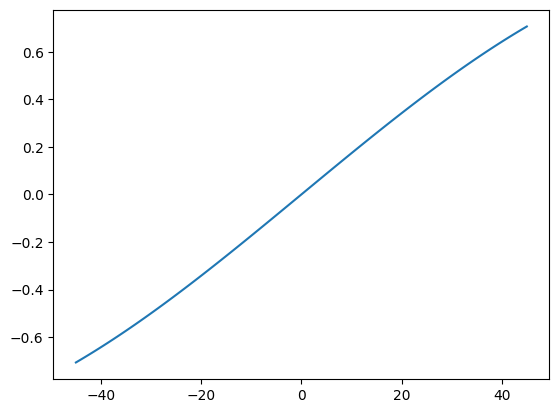

In [4]:
vorb = 1.0
theta = np.linspace(-45., 45., 100)
vx = vorb * np.sin(theta*(np.pi/180.))

plt.plot(theta, vx/vorb)
plt.show()

In [5]:
def calc_dt(dRp, a, P, phi=90.):
    # Function to calculate bias time (delta t) between
    #   median transit time and time of conjunction
    # INPUTS: dRp = limb size difference in [m]
    #         a = orbit semi-major axis in [m]
    #         P = orbital period in [s]
    #         phi = orbital phase at ingress
    # OUTPUTS: dt = bias time in [s]
    phase = phi * (np.pi/180.) # phase in [radian]
    vorb = (2.*np.pi*a)/P # orbital velocity in [m/s]
    vx = vorb * np.sin(phase)
    
    
    dt = 0.5*dRp / vx
    return dt

In [6]:
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7

In [7]:
def calc_T14(P, Rs, delta, b, a, inc):
    # P in [s], Rs in [m], a in [m], inc in [deg]
    num = Rs * np.sqrt((1. + delta)**2 - b**2)
    den = a * np.sin(inc*(np.pi/180.))
    dur = (P / np.pi) * np.asin((num/den))
    return dur

def ingressphase(T14, P):
    return (np.pi*T14)/P

In [10]:
## -- calculating an example for wasp-39 b
M_w39, T_w39, RpRs_w39, Rs_w39, mu_w39 = 0.281, 1166., 0.1457, 0.928, 2.3 # [Rj], [K],[], [Rsol]
a_w39, P_w39 = 0.0486, 4.055259 # [AU], [day]
Merr_w39, Terr_w39, RpRserr_w39, Rserr_w39, muerr_w39 = 0.032, 14., 0.0015, 0.03, 0.25
b_w39 = 0.447
inc_w39 = 87.83 # [deg]



Rp1_w39 = convert_rprs_to_rpJ(RpRs_w39, Rs_w39)
Rp1err_w39 = 9.73116*np.sqrt((Rs_w39**2 * RpRserr_w39**2) + (RpRs_w39**2 * Rserr_w39**2))
H_w39 = calc_scale_height(T_w39, M_w39, Rp1_w39, mu_w39) # [km]
Herr_w39 = calc_scale_height_error(T_w39, M_w39, Rp1_w39, mu_w39, Terr_w39, Merr_w39, Rp1err_w39, muerr_w39)

dRp_test = 1. * (H_w39 * 1000.)
a_test = a_w39 * AU_to_meter
P_test = P_w39 * day_to_second
dt_test = calc_dt(dRp_test, a_test, P_test)
print('test -- dt = %.2f seconds'%(dt_test))

test -- dt = 3.81 seconds


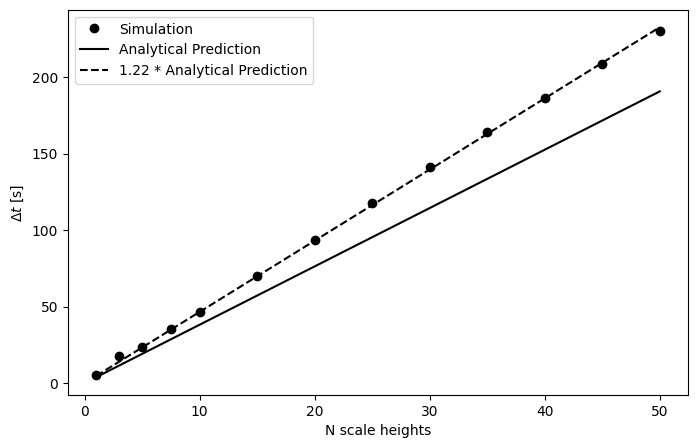

In [11]:
## WASP-39 b numerical results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw39= np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw39, tAw39, terrAw39 = resAw39['fasyms'], resAw39['tdiff_seconds'], resAw39['tdiff_err_seconds']
resBw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw39, tBw39, terrBw39 = resBw39['fasyms'], resBw39['tdiff_seconds'], resBw39['tdiff_err_seconds']
resCw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw39, tCw39, terrCw39 = resCw39['fasyms'], resCw39['tdiff_seconds'], resCw39['tdiff_err_seconds']
fw39, tw39, terrw39 = np.concatenate((fAw39, fBw39, fCw39)), np.concatenate((tAw39, tBw39, tCw39)),np.concatenate((terrAw39, terrBw39, terrCw39))
    
## analytic calc
dRp = fAw39*H_w39*1000. # [m]
dt_analytic = calc_dt(dRp, (a_w39*AU_to_meter), (P_w39*day_to_second))

## plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fAw39, abs(tAw39), marker='o', ls='None', c='black', label='Simulation')
ax.plot(fAw39, dt_analytic, c='black', label='Analytical Prediction')
ax.plot(fAw39, 1.22*dt_analytic, c='black', ls='--', label='1.22 * Analytical Prediction')
ax.set(xlabel='N scale heights', ylabel='$\Delta t$ [s]')
ax.legend(loc='upper left')
#ax.set(xlim=(0,20))
plt.show()

In [26]:
## WASP-96 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw96= np.load('output_arrays/synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw96, tAw96, terrAw96 = resAw96['fasyms'], resAw96['tdiff_seconds'], resAw96['tdiff_err_seconds']
resBw96 = np.load('output_arrays/synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw96, tBw96, terrBw96 = resBw96['fasyms'], resBw96['tdiff_seconds'], resBw96['tdiff_err_seconds']
resCw96 = np.load('output_arrays/synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw96, tCw96, terrCw96 = resCw96['fasyms'], resCw96['tdiff_seconds'], resCw96['tdiff_err_seconds']
fw96, tw96, terrw96 = np.concatenate((fAw96, fBw96, fCw96)), np.concatenate((tAw96, tBw96, tCw96)), np.concatenate((terrAw96, terrBw96, terrCw96))

## WASP-107 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw107= np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw107, tAw107, terrAw107 = resAw107['fasyms'], resAw107['tdiff_seconds'], resAw107['tdiff_err_seconds']
resBw107 = np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw107, tBw107, terrBw107 = resBw107['fasyms'], resBw107['tdiff_seconds'], resBw107['tdiff_err_seconds']
resCw107 = np.load('output_arrays/wasp107b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw107, tCw107, terrCw107 = resCw107['fasyms'], resCw107['tdiff_seconds'], resCw107['tdiff_err_seconds']
fw107, tw107, terrw107 = np.concatenate((fAw107, fBw107, fCw107)), np.concatenate((tAw107, tBw107, tCw107)),np.concatenate((terrAw107, terrBw107, terrCw107))

## GJ-1214 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAgj1214= np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAgj1214, tAgj1214, terrAgj1214 = resAgj1214['fasyms'], resAgj1214['tdiff_seconds'], resAgj1214['tdiff_err_seconds']
resBgj1214 = np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBgj1214, tBgj1214, terrBgj1214 = resBgj1214['fasyms'], resBgj1214['tdiff_seconds'], resBgj1214['tdiff_err_seconds']
resCgj1214 = np.load('output_arrays/gj1214b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCgj1214, tCgj1214, terrCgj1214 = resCgj1214['fasyms'], resCgj1214['tdiff_seconds'], resCgj1214['tdiff_err_seconds']
fgj1214, tgj1214, terrgj1214 = np.concatenate((fAgj1214, fBgj1214, fCgj1214)), np.concatenate((tAgj1214, tBgj1214, tCgj1214)), np.concatenate((terrAgj1214, terrBgj1214, terrCgj1214))
 
## WASP-39 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw39= np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw39, tAw39, terrAw39 = resAw39['fasyms'], resAw39['tdiff_seconds'], resAw39['tdiff_err_seconds']
resBw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw39, tBw39, terrBw39 = resBw39['fasyms'], resBw39['tdiff_seconds'], resBw39['tdiff_err_seconds']
resCw39 = np.load('output_arrays/wasp39b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw39, tCw39, terrCw39 = resCw39['fasyms'], resCw39['tdiff_seconds'], resCw39['tdiff_err_seconds']
fw39, tw39, terrw39 = np.concatenate((fAw39, fBw39, fCw39)), np.concatenate((tAw39, tBw39, tCw39)),np.concatenate((terrAw39, terrBw39, terrCw39))
    
## WASP-80 b results
# with PandExo cadence, 100 ppm scatter, ahead 1k
resAw80= np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenA_nircCadencekeyoutputs.npz')
fAw80, tAw80, terrAw80 = resAw80['fasyms'], resAw80['tdiff_seconds'], resAw80['tdiff_err_seconds']
resBw80 = np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenB_nircCadencekeyoutputs.npz')
fBw80, tBw80, terrBw80 = resBw80['fasyms'], resBw80['tdiff_seconds'], resBw80['tdiff_err_seconds']
resCw80 = np.load('output_arrays/wasp80b_synth_scatter100_ahead1000LDscenC_nircCadencekeyoutputs.npz')
fCw80, tCw80, terrCw80 = resCw80['fasyms'], resCw80['tdiff_seconds'], resCw80['tdiff_err_seconds']
fw80, tw80, terrw80 = np.concatenate((fAw80, fBw80, fCw80)), np.concatenate((tAw80, tBw80, tCw80)),np.concatenate((terrAw80, terrBw80, terrCw80))    
    
## Limb darkening coefficient cases
u1A, u2A= 0.1777 , 0.2952
u1B, u2B = 0.25, 0.45
u1C, u2C = 0.6, 0.2952

# Prop t0 uncertainties after 1,000 transits
propw96 = 1.235466*60. #[s]
propw107 = 4.341546*60.
propgj1214 = 0.209944*60.
propw39 = 4.979340*60.
propw80 = 0.279597*60.

## computing the scale heights as done in the simulations
M_w96, T_w96, RpRs_w96, Rs_w96, mu_w96 = 0.49, 1285., 0.1186, 1.15, 2.3
Merr_w96, Terr_w96, RpRserr_w96, Rserr_w96, muerr_w96 = 0.04, 40., 0.0017, 0.03, 0.25
a_w96, P_w96 = 0.0453, 3.4252602 # [au], [day]
Rp1_w96 = convert_rprs_to_rpJ(RpRs_w96, Rs_w96)
Rp1err_w96 = 9.73116*np.sqrt((Rs_w96**2 * RpRserr_w96**2) + (RpRs_w96**2 * Rserr_w96**2)) # 9.7... = Rsun -> Rjup conversion
H_w96 = calc_scale_height(T_w96, M_w96, Rp1_w96, mu_w96)
Herr_w96 = calc_scale_height_error(T_w96, M_w96, Rp1_w96, mu_w96, Terr_w96, Merr_w96, Rp1err_w96, muerr_w96)

M_w107, T_w107, RpRs_w107, Rs_w107, mu_w107 = 0.096, 770., 0.14434, 0.73, 2.5
Merr_w107, Terr_w107, RpRserr_w107, Rserr_w107, muerr_w107 = 0.005, 60., 0.00018, 0.15, 0.25
a_w107, P_w107 = 0.055, 5.721488 # [au], [day]
Rp1_w107 = convert_rprs_to_rpJ(RpRs_w107, Rs_w107)
Rp1err_w107 = 0.02 # using this one is inflated by Rs err -> 9.73116*np.sqrt((Rs_w107**2 * RpRserr_w107**2) + (RpRs_w107**2 * Rserr_w107**2))
H_w107 = calc_scale_height(T_w107, M_w107, Rp1_w107, mu_w107)
Herr_w107 = calc_scale_height_error(T_w107, M_w107, Rp1_w107, mu_w107, Terr_w107, Merr_w107, Rp1err_w107, muerr_w107)

M_gj1214, T_gj1214, RpRs_gj1214, Rs_gj1214, mu_gj1214 = 0.0257, 596., 0.1160, 0.215, 5.0
Merr_gj1214, Terr_gj1214, RpRserr_gj1214, Rserr_gj1214, muerr_gj1214 = 0.0014, 19., 0.0005, 0.008, 0.25
a_gj1214, P_gj1214 = 0.01490, 1.5804043 # [au], [day]
Rp1_gj1214 = convert_rprs_to_rpJ(RpRs_gj1214, Rs_gj1214)
Rp1err_gj1214 = 9.73116*np.sqrt((Rs_gj1214**2 * RpRserr_gj1214**2) + (RpRs_gj1214**2 * Rserr_gj1214**2))
H_gj1214 = calc_scale_height(T_gj1214, M_gj1214, Rp1_gj1214, mu_gj1214)
Herr_gj1214 = calc_scale_height_error(T_gj1214, M_gj1214, Rp1_gj1214, mu_gj1214, Terr_gj1214, Merr_gj1214, Rp1err_gj1214, muerr_gj1214)

M_w39, T_w39, RpRs_w39, Rs_w39, mu_w39 = 0.281, 1166., 0.1457, 0.928, 2.3
Merr_w39, Terr_w39, RpRserr_w39, Rserr_w39, muerr_w39 = 0.032, 14., 0.0015, 0.03, 0.25
a_w39, P_w39 = 0.0486, 4.055259 # [AU], [day]
Rp1_w39 = convert_rprs_to_rpJ(RpRs_w39, Rs_w39)
Rp1err_w39 = 9.73116*np.sqrt((Rs_w39**2 * RpRserr_w39**2) + (RpRs_w39**2 * Rserr_w39**2))
H_w39 = calc_scale_height(T_w39, M_w39, Rp1_w39, mu_w39)
Herr_w39 = calc_scale_height_error(T_w39, M_w39, Rp1_w39, mu_w39, Terr_w39, Merr_w39, Rp1err_w39, muerr_w39)

M_w80, T_w80, RpRs_w80, Rs_w80, mu_w80 = 0.538, 825., 0.17137, 0.605, 2.3
Merr_w80, Terr_w80, RpRserr_w80, Rserr_w80, muerr_w80 = 0.035, 19., 0.00039, 0.048, 0.25
a_w80, P_w80 = 0.0344, 3.0678523 # [au], [day]
Rp1_w80 = convert_rprs_to_rpJ(RpRs_w80, Rs_w80)
Rp1err_w80 = 9.73116*np.sqrt((Rs_w80**2 * RpRserr_w80**2) + (RpRs_w80**2 * Rserr_w80**2))
H_w80 = calc_scale_height(T_w80, M_w80, Rp1_w80, mm=mu_w80)
Herr_w80 = calc_scale_height_error(T_w80, M_w80, Rp1_w80, mu_w80, Terr_w80, Merr_w80, Rp1err_w80, muerr_w80)

Teqs = np.array([T_gj1214, T_w80, T_w96, T_w39, T_w107])
radii1 = np.array([Rp1_gj1214, Rp1_w80, Rp1_w96, Rp1_w39, Rp1_w107])
masses = np.array([M_gj1214, M_w80, M_w96, M_w39, M_w107])
scaleheights = np.array([H_gj1214, H_w80, H_w96, H_w39, H_w107])
scaleheight_errs = np.array([Herr_gj1214, Herr_w80, Herr_w96, Herr_w39, Herr_w107])

labels = np.array(['GJ-1214 b', 'WASP-80 b', 'WASP-96 b', 'WASP-39 b', 'WASP-107 b'])

In [27]:
## analytic calc
dt_gj1214 = calc_dt((fAgj1214*H_gj1214*1000.), (a_gj1214*AU_to_meter), (P_gj1214*day_to_second))
dt_w80 = calc_dt((fAw80*H_w80*1000.), (a_w80*AU_to_meter), (P_w80*day_to_second))
dt_w96 = calc_dt((fAw96*H_w96*1000.), (a_w96*AU_to_meter), (P_w96*day_to_second))
dt_w39 = calc_dt((fAw39*H_w39*1000.), (a_w39*AU_to_meter), (P_w39*day_to_second))
dt_w107 = calc_dt((fAw107*H_w107*1000.), (a_w107*AU_to_meter), (P_w107*day_to_second))

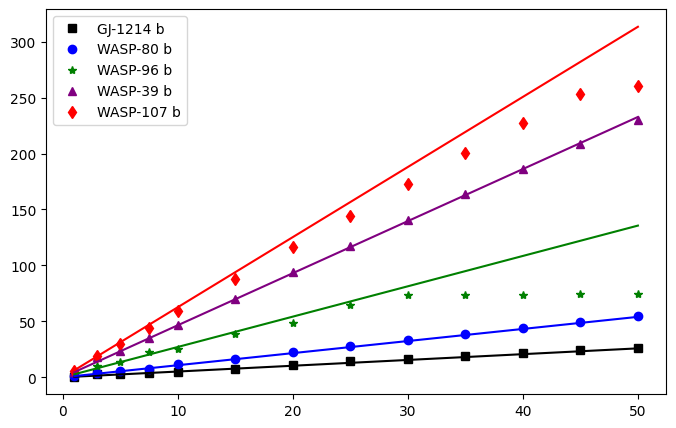

In [30]:
## plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fAgj1214, abs(tAgj1214), marker='s', ls='None', c='black', label='GJ-1214 b')
ax.plot(fAw80, abs(tAw80), marker='o', ls='None', c='blue', label='WASP-80 b')
ax.plot(fAw96, abs(tAw96), marker='*', ls='None', c='green', label='WASP-96 b')
ax.plot(fAw39, abs(tAw39), marker='^', ls='None', c='purple', label='WASP-39 b')
ax.plot(fAw107, abs(tCw107), marker='d', ls='None', c='red', label='WASP-107 b')

ax.plot(fAgj1214, 1.22*dt_gj1214, c='black')
ax.plot(fAw80, 1.22*dt_w80, c='blue')
ax.plot(fAw96, 1.22*dt_w96, c='green')
ax.plot(fAw39, 1.22*dt_w39, c='purple')
ax.plot(fAw107, 1.22*dt_w107, c='red')
ax.legend(loc='best')
plt.show()